In [2]:
!nvidia-smi

Wed Mar 20 15:34:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.52                 Driver Version: 551.52         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   52C    P8             25W /  200W |     858MiB /   8192MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip install opencv-python

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 660.6 kB/s eta 0:00:59
   ---------------------------------------- 0.1/38.6 MB 544.7 kB/s eta 0:01:11
   ---------------------------------------- 0.1/38.6 MB 726.2 kB/s eta 0:00:54
   ---------------------------------------- 0.2/38.6 MB 821.4 kB/s eta 0:00:47
   ---------------------------------------- 0.2/38.6 MB 919.0 kB/s eta 0:00:42
   ---------------------------------------- 0.3/38.6 MB 1.1 MB/s eta 0:00:34
   ---------------------------------------- 0.5/38.6 MB 1.4 MB/s eta 0:00:28
    --------------------------------------- 0.7/38.6 MB 1.8 MB/s eta 0:00:22
    --------------------------------------- 0.9/38.6 MB 2.2 MB/s eta 0:00:18
   - -------------------------------------- 1.2/38.6 MB 2.6 MB/s eta 0:00:15
   - -------------------------------------- 1.5/38.6 MB 3.0 MB/s eta 0:00:13
   

In [6]:
!pip install tensorflow

     ---------------------------------------- 0.0/46.1 kB ? eta -:--:--
     -------------------------- ------------- 30.7/46.1 kB 1.3 MB/s eta 0:00:01
     --------------------------------- ---- 41.0/46.1 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 46.1/46.1 kB 381.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/377.0 MB 1.3 MB/s eta 0:04:49
   ---------------------------------------- 0.1/377.0 MB 1.3 MB/s eta 0:04:49
   ---------------------------------------- 0.2/377.0 MB 1.3 MB/s eta 0:04:49
   ---------------------------------------- 0.2/377.0 MB 1.4 MB/s eta 0:04:34
   ---------------------------------------- 0.5/377.0 MB 1.8 MB/s eta 0:03:34
   ---------------------------------------- 0.5/377.0 MB 1.8 MB/s eta 0:03:25
   ---------------------------------------- 0.8/377.0 MB 2.4 MB/s eta 0:02:40
   ---------------------------------------- 1.0/377.0 MB 2.7 MB/s eta 0

In [1]:
import os
import shutil
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

temp_path = "/content/drive/My Drive/feature_extraction/temp_frames/"
feat_path = "/content/drive/My Drive/feature_extraction/all_feat16/"
all_video_path = "/content/drive/My Drive/feature_extraction/MSRVTT_videos/"
num_of_frames = 16 # vs 80

def feat_extraction(video, model):
    video_path = os.path.join(all_video_path, video) # Path to video file
    os.makedirs(temp_path) # Creating a temporary path to save all frames from video
    all_frames_paths = []
    video_cap = cv2.VideoCapture(video_path)
    num = 0 # Number of current frame
    # Obtaining all frames from the current video:
    while video_cap.isOpened():
        ret, frame = video_cap.read()
        if ret == False: # if frame is not captured
            break
        cv2.imwrite(os.path.join(temp_path, 'frame' + str(num) + '.jpg'), frame)
        all_frames_paths.append(os.path.join(temp_path, 'frame' + str(num) + '.jpg'))
        num += 1

    video_cap.release()
    cv2.destroyAllWindows()

    # Taking only 16 (or 80) frames which are fairly spread over the video:
    frame_nums = np.round(np.linspace(0, len(all_frames_paths) - 1, num_of_frames))
    frames_paths = []
    for n in frame_nums:
        frames_paths.append(all_frames_paths[int(n)]) # Path to each frame

    frames = np.zeros((num_of_frames, 224, 224, 3)) # (224, 224, 3) is required frame size by VGG16
    for i, path in enumerate(frames_paths): # From 0 to 80 (or 16)
        image = cv2.imread(path)
        image = cv2.resize(image, (224, 224)) # Resizing frames to (224, 224)
        frames[i] = image

    frames_feat = model.predict(frames, batch_size=64) # Extracting feature by VGG16 model
    frames_feat = np.array(frames_feat)
    shutil.rmtree(temp_path) # Deleting a temporary path
    return frames_feat

# Creating the VGG16 Model and calling feat_extraction for each video:
model_vgg16 = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
# VGG16 has 23 layers, last layer is "predictions (Dense)"
# Removing "predictions" layer from VGG16 model
output = model_vgg16.layers[21].output
model = Model(inputs=model_vgg16.input, outputs=output)
model.summary()
video_count = 0

for video in os.listdir(os.path.join(all_video_path)):
    npyfeat = os.path.join(feat_path, video + '.npy')
    feat = feat_extraction(video, model) # Size is 16x4096 (or 80x4096 if 16 frames)
    np.save(npyfeat, feat)
    video_count += 1
    print("Extracting feature for the video:", video)
    print("Extracted video number: ", video_count)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracting feature for the video: video9010.mp4
Extracted video number:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracting feature for the video: video9011.mp4
Extracted video number:  2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracting feature for the video: video9012.mp4
Extracted video number:  3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracting feature for the video: video9013.mp4
Extracted video number:  4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracting feature for the video: video9014.mp4
Extracted video number:  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracting feature for the video: video9015.mp4
Extracted video number:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracting feature for the video: video9016.mp4
Extracted video number:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracting feature for the video: video9017.mp4
Extracted video number:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Extracting feature for the video: video9018.mp4
Extracted video number:  9
1

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
model_vgg16 = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
model_vgg16.summary() # summary of all layers in VGG16





Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

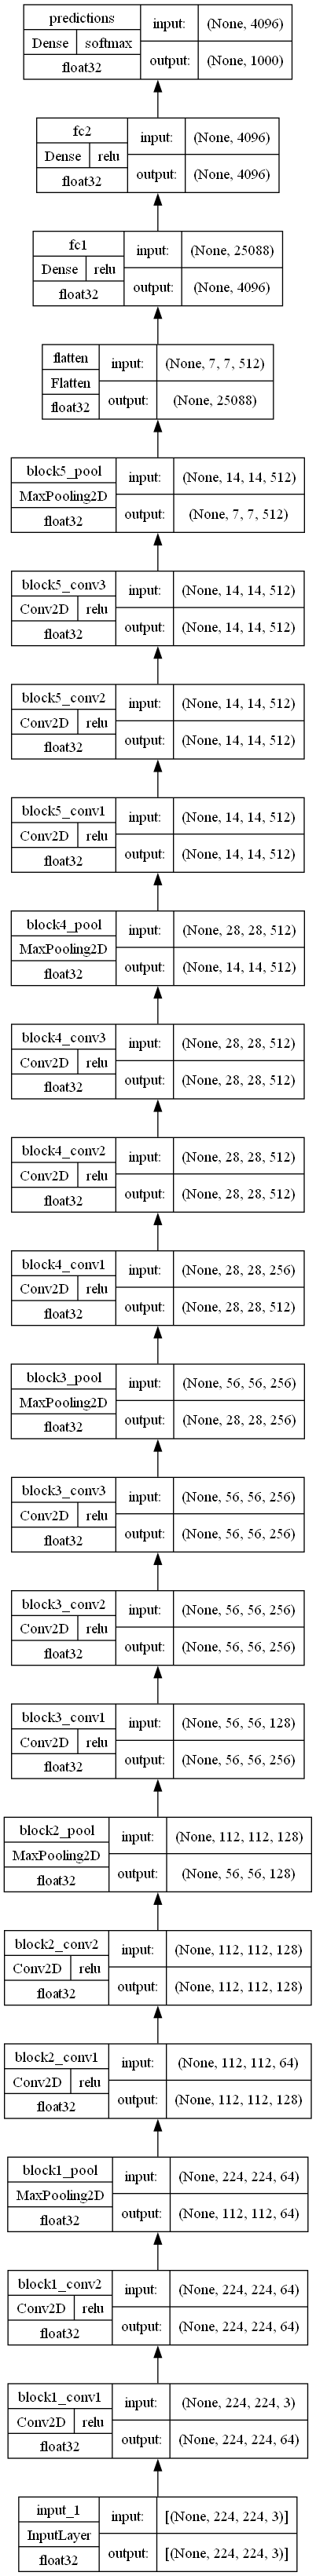

In [ ]:
from keras.utils import plot_model
plot_model(model_vgg16, "model_vgg16.png", show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='BT', show_layer_activations=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

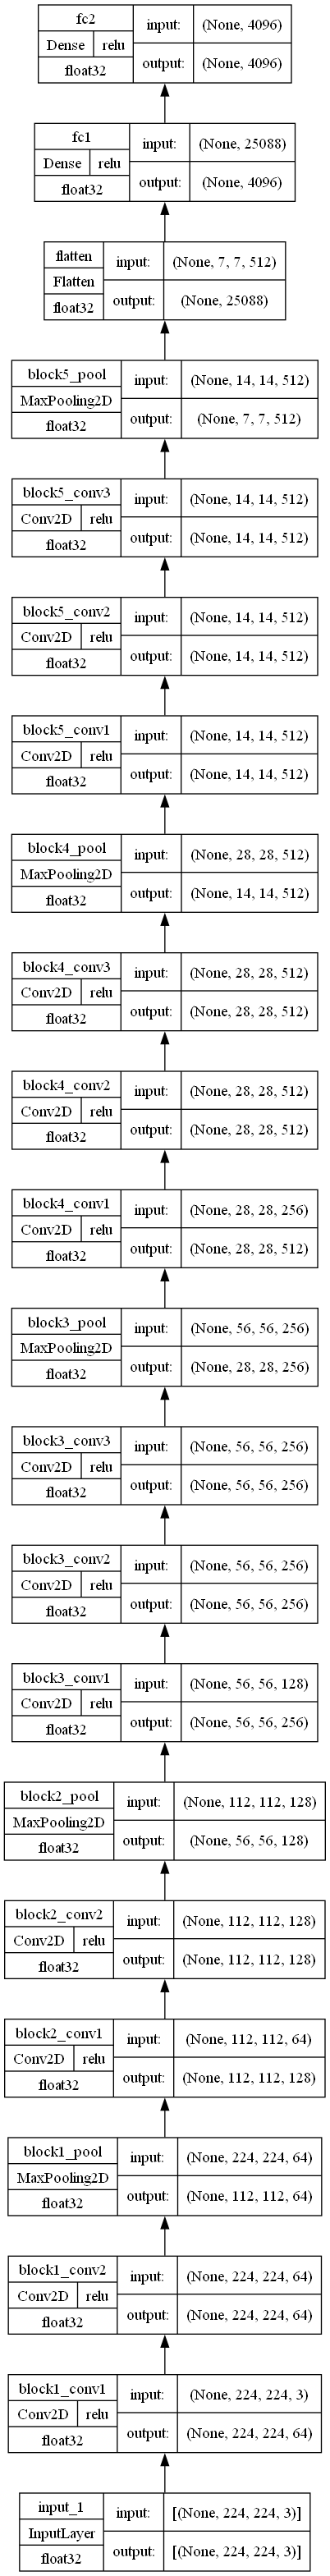

In [ ]:
output = model_vgg16.layers[-2].output
model = Model(inputs=model_vgg16.input, outputs=output)
model.summary()
plot_model(model, "model.png", show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='BT', show_layer_activations=True)


In [ ]:
len(model_vgg16.layers)

23

In [ ]:
#model_vgg16 = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
output1 = model_vgg16.layers[21].output # Removing "predictions" layer from VGG16 model
model1 = Model(inputs=model_vgg16.input, outputs=output1)
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   